In [1]:
# These codes are made for calculating the asymmetric parameter eta.

# Authors: 
# Zehao Zhong (zhzhong@nao.cas.cn)
# Gang Zhao
# Hans-Walter Rix
# Luis C. Ho

# This example is used to calculate the asymmetry parameter, and could reproduced the results in our article (Fig. 2, Fig. 3).


# You may need these reference:
# Our paper (Under Review)
# (Data and tables from SAMI survey Dr3):
# Croom, S. et al. 2021, MNRAS, 505, 991–1016 (SAMI survey Dr3)
# Owers, M. et al. 2017, MNRAS, 468, 1824–1849 (table InputCatClustersDR3)
# D’Eugenio, F. et al. 2021, MNRAS, 504, 5098–5130 (table MGEPhotomUnregDR3)
# Cortese, L. et al. 2016, MNRAS, 463, 170–184 (table VisualMorphologyDR3)
# van de Sande, J. et al. 2017, APJ, 835, 104 (stellar kinematics)
# Bryant, J. et al. 2015, MNRAS, 447, 2857–2879 (table InputCatGAMADR3)
# (COBS – Constrained B-splines)
# Ng P, Maechler M (2007). “A Fast and Efficient Implementation of Qualitatively Constrained Quantile Smoothing Splines.” Statistical Modelling, 7(4), 315–328. doi:10.1177/1471082X0700700403.
# Ng PT, Maechler M (2022). COBS – Constrained B-splines (Sparse matrix based). R package version 1.3-5., https://CRAN.R-project.org/package=cobs.


# The details of these codes are showed in the 'Methods' section of our paper.

# If you would like to replot the figures in our article, please download the 
# corresponding SAMI data and tables, and then run the program. The method 
# of calculating eta of TNG DATA is similar, and the code is not repeated here.

# Or if you would like to calculate the asymmetric parameter eta of your 
# own IFU data. Please look at the core function 'calind2inv3' and 'calchinreMCv14',
# you can also refer to function 'asymparaquanall'

# Please note that modify the corresponding path to your own path when running the program.

In [2]:
#These are the python libraries pre-needed.
import numpy as np
from astropy.io import fits
import os
import pandas as pd
import time
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [3]:
import matplotlib
matplotlib.rcParams['font.size']=16
matplotlib.rcParams['legend.fontsize']=15
matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['axes.labelsize']=21
matplotlib.rcParams['axes.titlesize']=21

In [4]:
def rms_coor_tran4(rms,erms,vsn,theta,tsn=10,X=0,Y=0): #'theta' could be 'theta' from 'find_galaxy' of mge.
    #Get coordinates non NaN.
    rms_nan=np.isnan(rms)
    erms_nan=np.isnan(erms)
    vsnltsn=np.flatnonzero(vsn>=tsn)
    indrmsOK=np.flatnonzero(rms>erms)
    ind = np.intersect1d(np.flatnonzero(rms_nan== 0),np.flatnonzero(erms_nan== 0))
    ind=np.intersect1d(ind,vsnltsn)
    ind=np.intersect1d(ind,indrmsOK)
    s=rms.shape
    y0,x0=np.unravel_index(ind, s) #Note that np.unravel_index results in the reverse (y0,x0).
    x1=x0-24.5-X #The center coordinate is (25.5,25.5), but since it is from 0 to 49, it needs to subtract 24.5.
    y1=y0-24.5-Y
    theta1=theta/180*np.pi
    xbin=x1*np.cos(theta1)+(-y1)*np.sin(theta1)
    ybin=x1*np.sin(theta1)+y1*np.cos(theta1)
    return xbin,ybin,ind,x1,y1 #return coordinates
def calind2inv3(x2,y2,r_e,eps_e=0,pixsize_v=0.5):
    a=r_e/np.sqrt((1-eps_e))
    b=r_e*np.sqrt((1-eps_e))
    ind2=np.flatnonzero(((x2*pixsize_v/a)**2+(y2*pixsize_v/b)**2)<=1)
    indcoorsym0=-1*np.ones_like(ind2)
    ind2inv=np.zeros_like(ind2)
    for i in range(len(ind2)):
        coorsym=(-x2[ind2][i]==x2[ind2])*(-y2[ind2][i]==y2[ind2])
        indcoorsym0[i]=np.sum(coorsym)
        if indcoorsym0[i]==1:
            ind2inv[i]=ind2[np.flatnonzero(coorsym==1)]
    indcoorsym=np.flatnonzero(indcoorsym0==1)
    ind2=ind2[indcoorsym]
    ind2inv=ind2inv[indcoorsym]
    return ind2,ind2inv,indcoorsym0
#The maxchi2pc parameter controls the percentage of spaxels required.
def calchinreMCv14(x2,y2,r_e,rms2,erms2,c_fluxsumflat,c_fluxsumflaterr,eps_e=0,pixsize_v=0.5,maxchi2pc=90):
    ind2,ind2inv,indcoorsym=calind2inv3(x2,y2,r_e,eps_e=eps_e,pixsize_v=pixsize_v)
    max2ne=np.abs(rms2[ind2]**2-rms2[ind2inv]**2)-2*rms2[ind2]*erms2[ind2]-2*rms2[ind2inv]*erms2[ind2inv]
    chi2ne=(2*(max2ne>0)*max2ne/(rms2[ind2]**2+rms2[ind2inv]**2))
    chi2=2*np.abs(rms2[ind2]**2-rms2[ind2inv]**2)/(rms2[ind2]**2+rms2[ind2inv]**2)
    maxchi2=np.percentile(chi2,maxchi2pc)
    indchi2=np.flatnonzero(chi2<=maxchi2)
    chi2sum=np.sum((chi2*c_fluxsumflat[ind2])[indchi2])/(np.sum((c_fluxsumflat[ind2])[indchi2]))
    chi2nesum=np.sum((chi2ne*c_fluxsumflat[ind2])[indchi2])/(np.sum((c_fluxsumflat[ind2])[indchi2]))
    #############
    maxLne=np.abs(c_fluxsumflat[ind2]-c_fluxsumflat[ind2inv])-c_fluxsumflaterr[ind2]-c_fluxsumflaterr[ind2inv]
    chiLne=2*(maxLne>0)*maxLne/(c_fluxsumflat[ind2]+c_fluxsumflat[ind2inv])
    chiL=2*np.abs(c_fluxsumflat[ind2]-c_fluxsumflat[ind2inv])/(c_fluxsumflat[ind2]+c_fluxsumflat[ind2inv])
    maxchiL=np.percentile(chiL,maxchi2pc)
    indchiL=np.flatnonzero(chiL<=maxchiL)
    chiLsum=np.sum(chiL[indchiL]*c_fluxsumflat[ind2][indchiL])/(np.sum(c_fluxsumflat[ind2][indchiL]))
    chiLnesum=np.sum(chiLne[indchiL]*c_fluxsumflat[ind2][indchiL])/(np.sum(c_fluxsumflat[ind2][indchiL]))
    return ind2,ind2inv,indchi2,chi2,chi2sum,chi2nesum,chiL,chiLsum,chiLnesum

In [5]:
def asymparaquan(galname,file1vel,file1sig,pamge,epsmge_re,remge,mstar2,pixsize_v=0.5,tsn=0,maxchi2pc=90,cmap='sauron'):
    hdu1vel = fits.open(file1vel)
    hdu1sig = fits.open(file1sig)
    vel1 = hdu1vel[0].data
    sig1 = hdu1sig[0].data
    evel1=hdu1vel[1].data
    esig1=hdu1sig[1].data
    sn1=hdu1vel[4].data
    rms1=np.sqrt(vel1**2+sig1**2)
    erms1=np.sqrt((evel1*vel1)**2+(esig1*sig1)**2)/rms1
    x2,y2,ind,x1,y1=rms_coor_tran4(rms1,erms1,sn1,270-pamge,tsn=tsn)#The unit is pixel. And theta=270-pamge.
    #Here x1,y1 are corresponding x2,y2 before rotation.
    sn2=sn1.flatten()[ind]
    vel2=vel1.flatten()[ind]
    evel2=evel1.flatten()[ind]
    sig2=sig1.flatten()[ind]
    esig2=esig1.flatten()[ind]
    #Flux
    c_fluxsum=hdu1vel[2].data
    c_fluxsumerr=hdu1vel[3].data
    c_fluxsumflat=c_fluxsum.flatten()
    c_fluxsumflaterr=c_fluxsumerr.flatten()
    ind2,ind2inv,indcoorsym=calind2inv3(x2,y2,remge,eps_e=epsmge_re,pixsize_v=pixsize_v)
    #The total number of spaxels within the effective radius
    rms1_one=np.ones_like(rms1)
    x2_one,y2_one,ind_one,x1_one,y1_one=rms_coor_tran4(2*rms1_one,rms1_one,rms1_one,270-pamge,tsn=tsn)
    ind2_one,ind2inv_one,indcoorsym_one=calind2inv3(x2_one,y2_one,remge,eps_e=epsmge_re,pixsize_v=pixsize_v)
    #Subtract residual velocity
    mv0 = np.mean(vel2[ind2])
    vel2 = vel2 - mv0
    rms2=np.sqrt(vel2**2+sig2**2)
    erms2=np.sqrt((evel2*vel2)**2+(esig2*sig2)**2)/rms2
    if len(ind2)==0:
        chi2sum,chi2nesum,chiLsum,chiLnesum=np.array([-1]),np.array([-1]),np.array([-1]),np.array([-1])
        print('finish'+str(galname)+',empty')
    else: 
        ind2,ind2inv,indchi2,chi2,chi2sum,chi2nesum,chiL,chiLsum,chiLnesum=calchinreMCv14(x2,y2,remge,rms2,erms2,c_fluxsumflat[ind],c_fluxsumflaterr[ind],eps_e=epsmge_re,pixsize_v=pixsize_v,maxchi2pc=maxchi2pc)
        print('finish'+str(galname))
    return x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum,chiLsum,chiLnesum
def asymparaquanall(galname,pathfile,tsn=0,maxchi2pc=90,momtn=2,plots=0,cmap='sauron'):
    if galname<10e8:
        ggroup=1
    else:
        ggroup=0
    #ggroup=1 means gamagroup,=0 means cluster regions.
    #Should change the path to your own path.
    os.chdir(pathfile+'/samiserdr3/tables')
    file1=pathfile+'/samiserdr3/tables/others/sami_dr3_MGEPhotomUnregDR3.csv'
    dr2tsk=pd.read_csv(file1) #table for sample and kinematics
    indamet=np.flatnonzero(dr2tsk.catid.values==galname)
    pixsize_v=0.5#arcsec/pixel
    if len(indamet)>1:
        for i in range(len(indamet)):
            if dr2tsk.photometry[indamet[i]]=="VST":
                pamge=dr2tsk.pamge[indamet[i]]
                epsmge_re=dr2tsk.epsmge_re[indamet[i]]
                remge=dr2tsk.remge[indamet[i]]
    elif len(indamet)==1:
        pamge=dr2tsk.pamge[indamet[0]]
        epsmge_re=dr2tsk.epsmge_re[indamet[0]]
        remge=dr2tsk.remge[indamet[0]]
    file4=pathfile+'/samiserdr3/tables/others/sami_dr3_InputCatGAMADR3.csv'
    dr2tsk4=pd.read_csv(file4)
    file5=pathfile+'/samiserdr3/tables/others/Sami_dr3_InputCatClustersDR3.csv'
    dr2tsk5=pd.read_csv(file5)
    if galname<1e8:
        indamet4=np.flatnonzero(dr2tsk4.catid.values==galname)
        mstar2=dr2tsk4.mstar[indamet4[0]]
    else:
        indamet5=np.flatnonzero(dr2tsk5.catid.values==galname)
        mstar2=dr2tsk5.mstar[indamet5[0]]  
    
    ##sami-mge-velmap
    if momtn==2:
        momtnstr='two'
        os.chdir(pathfile+'/samiserdr3/cubes/samidr3vel_sigma_'+momtnstr+'mom/'+str(galname))
        obsnum=int(len(os.listdir())/2)
    elif momtn==4:
        momtnstr='four'
        os.chdir(pathfile+'/samiserdr3/cubes/samidr3vel_sigma_'+momtnstr+'mom/'+str(galname))
        obsnum=int(len(os.listdir())/4)
    file_dir=os.getcwd()
    file1vel=file_dir+'/'+str(galname)+'_A_stellar-velocity_default_'+momtnstr+'-moment.fits'
    file1sig=file_dir+'/'+str(galname)+'_A_stellar-velocity-dispersion_default_'+momtnstr+'-moment.fits'
    x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum,chiLsum,chiLnesum=asymparaquan(galname,file1vel,file1sig,pamge,epsmge_re,remge,mstar2,pixsize_v=pixsize_v,tsn=tsn,maxchi2pc=maxchi2pc,cmap=cmap)
    return x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum,chiLsum,chiLnesum

In [6]:
#Load tables.
pathfile='/home/xycrab/worksp01/hpworkstation/sami_myfit'
file2=pathfile+'/samiserdr3/tables/others/sami_dr3_VisualMorphologyDR3.csv'
dr2tsk2=pd.read_csv(file2) #table for sample and kinematics
galnameall2=dr2tsk2.catid.values
file3=pathfile+'/samiserdr3/tables/others/sami_dr3_MGEPhotomUnregDR3.csv'
dr2tsk3=pd.read_csv(file3) #table for sample and kinematics
galnameall3=dr2tsk3.catid.values
file4=pathfile+'/samiserdr3/tables/others/sami_dr3_InputCatGAMADR3.csv'
dr2tsk4=pd.read_csv(file4)
file5=pathfile+'/samiserdr3/tables/others/Sami_dr3_InputCatClustersDR3.csv'
dr2tsk5=pd.read_csv(file5)
file7=pathfile+'/samiserdr3/tables/samimain/sami_dr3.samiDR3Stelkin.csv'
dr2tsk7=pd.read_csv(file7)
galnameall23=np.intersect1d(np.unique(galnameall3),galnameall2)
galnameall45=np.union1d(dr2tsk4.catid.values,dr2tsk5.catid.values)
#galnameall are all the galaxies we needed from SAMI DR3.
galnameall=np.intersect1d(galnameall23,galnameall45)
lensp=len(galnameall)

In [7]:
#Run spldgnfdr3v9 to get all \eta of galaxies.
T1=time.time()
maxchi2pc=100
asymparaquanall_pa=partial(asymparaquanall,pathfile=pathfile,tsn=0,maxchi2pc=maxchi2pc,plots=0)
asymparaquanall_1=[]
npool=50
pool=Pool(npool)
#asymparaquanall_1=pool.map(asymparaquanall_pa,galnameall[range(lensp)])
pool.close()
pool.join()
print(time.time()-T1)

finish16310
finish8487
finish6821
finish23737
finish40419
finish9352
finish71269
finish23865
finish23082
finish55160
finish31725
finish30784
finish16317
finish7139
finish54270
finish40420
finish8488
finish39057
finish23868
finish71352
finish136966
finish63777
finish17314
finish30786
finish49728
finish214211
finish16392
finish179665
finish31912
finish79866
finish8490
finish143735
finish203609
finish186803
finish54359
finish55227
finish177481
finish144327
finish49730
finish14552
finish23117
finish106507
finish41277
finish70107
finish7206
finish202360
finish85464
finish105519
finish16426
finish40445
finish204983
finish203684
finish91996
finish106549
finish84048
finish63779
finish144335
finish54375
finish91579
finish17390
finish47652
finish30847
finish65406
finish49734
finish39108
finish136980
finish56181
finish24013
finish23225
finish138066
finish184370
finish177518
finish85474
finish78425
finish143736
finish107503
finish14555
finish84106
finish136624
finish205020
finish202373
finish10661

finish136881
finish49670
finish65237
finish227290
finish106389
finish186406
finish238922
finish144239
finish30469
finish209680
finish40164
finish136602
finish91963
finish99795
finish79329
finish145073
finish31620
finish107454
finish208589
finish220320
finish143499
finish238325
finish221369
finish69844
finish98880
finish16294
finish220437
finish177303
finish228708
finish227317
finish227961
finish36880
finish93354
finish240432
finish55150
finish252057
finish22932
finish238094
finish208612
finish184283
finish220126
finish185510
finish214184
finish204876
finish179584
finish209697
finish71178
finish198631
finish238328
finish215579
finish230560
finish54202
finish186470
finish227970
finish99259
finish69864
finish79335
finish144243
finish230797
finish184354
finish145267
finish91545
finish49677
finish100162
finish136894
finish240449
finish91988
finish273296
finish238125
finish136605
finish238350
finish40197
finish227351
finish239092
finish30472
finish204877
finish209698
finish143605
finish22806

finish300821
finish418624
finish378104
finish346257
finish371145
finish511890
finish290396
finish376001
finish273850
finish288992
finish323854
finish508132
finish319196
finish419345
finish288461
finish238276
finish381225
finish252005
finish491475
finish508480
finish376282
finish509397
finish388390
finish372568
finish485823
finish271610
finish396833
finish278773
finish279818
finish418630
finish457615
finish220750
finish323194
finish273092
finish486782
finish289116
finish381229
finish508138
finish346440
finish422486
finish346892
finish386720
finish371959
finish319400
finish325007
finish463317
finish511892
finish493028
finish301937
finish382731
finish381502
finish419549
finish504730
finish517247
finish534793
finish231528
finish521894
finish508481
finish514022
finish296847
finish298665
finish289118
finish493621
finish220751
finish252008
finish288999
finish272190
finish376293
finish290423
finish346475
finish485833
finish238282
finish346894
finish397449
finish378142
finish534885
finish381802

/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


finish9008500535
finish508416
finish508938
finish618930


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finish509892
finish9008500120,empty
finish593117
finish570207
finish550328
finish9008500160
finish574692
finish9008500007
finish551656
finish600974
finish9008500450
finish609358
finish517070
finish534763
finish9008500723
finish9008500208
finish505979
finish573776
finish537226
finish517465
finish567983
finish544749
finish599839
finish9008500328
finish570214
finish594731
finish586494
finish9008500122
finish622770
finish623712
finish584013
finish9008500939
finish9008500256
finish3630943
finish506038
finish9008500082
finish622228
finish560208
finish610893
finish9011900009
finish618100
finish511456
finish598911
finish9008500454
finish537240
finish550330
finish9008500724
finish521736
finish9008500805
finish9008500128
finish9011900045
finish492384
finish561143
finish509012
finish9008500018
finish543498
finish610997
finish9008500333
finish593526
finish548835
finish9008500264
finish592216
finish623722
finish506070
finish536454
finish9008500951
finish9008500161
finish594785
finish584682
finish60

/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


finish601255
finish9008500221


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finish9011900101
finish9008500753
finish609598
finish9008500093,empty
finish623043
finish619104
finish574193
finish9008500043
finish622434
finish9011900017
finish9008500172
finish569466
finish9008500890
finish9008500296
finish9008500643
finish9011900757
finish9011900328
finish9011900156
finish9011900274
finish9011900520
finish575623
finish9008500759
finish9016800056
finish618144
finish599134
finish585035
finish718921
finish9008500096
finish9008500138
finish9016800156
finish9016800094
finish9016800232
finish9008500181
finish9011900198
finish9011900233
finish9011900019
finish623143
finish9008501218
finish569555
finish618942
finish9011900885
finish9008500892
finish9008500646
finish9011900441
finish9016800061
finish611223
finish609912
finish618151
finish9008500362
finish599877
finish9011900759
finish9011900329
finish9011900617
finish575625
finish622534
finish9008500302
finish9016800396
finish9011900371
finish550780
finish9011900060
finish3634556
finish9008500182
finish9016800304
finish5742

finish9403800064
finish9016800228
finish9239900478
finish9403800013
finish9016800138
finish9044200383
finish9239900024
finish9388000043
finish9403801062
finish9044200015
finish9044200204
finish9044200091
finish9388000269
finish9403800073
finish9091700063
finish9011900128
finish9403800184
finish9403800318
finish9239900492
finish9016800276
finish9403800507
finish9239900345
finish9016800010
finish9239900256
finish9388000067
finish9091700242
finish9016800143
finish9388000825
finish9044200025
finish9239900136
finish9403800746
finish9016800229
finish9044200104
finish9403800117
finish9239900034
finish9388000416
finish9011900418
finish9239900106
finish9239900645
finish9011900498
finish9016800080
finish9016800358
finish9403801088
finish9403800187
finish9403800016
finish9011900714
finish9044200027
finish9239900501
finish9388000044
finish9011900254
finish9403800077
finish9091700393
finish9239900185
finish9011900137
finish9016800287
finish9016800144
finish9239901253
finish9044200205
finish93880002

In [8]:
#np.save(pathfile+'/samiserdr3/asymparaquanall.npy',asymparaquanall_1,allow_pickle=True)

/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [7]:
maxchi2pc=100
asymparaquanall_1=np.load(pathfile+'/samiserdr3/asymparaquanall.npy',allow_pickle=True)

In [8]:
#Load data from tables.
lenspgama=np.sum(galnameall<=1e8)
lenspclu=np.sum(galnameall>1e8)
indtb2=np.zeros(lensp)
indtb3=np.zeros(lensp)
indtb4=np.zeros(lenspgama)
indtb5=np.zeros(lenspclu)
indtb7=np.zeros(lensp)
mstar2=np.zeros(lensp)
z_spec=np.zeros(lensp)
remge=np.zeros(lensp)
sigma_re_sami=np.zeros(lensp)
psymcon2=asymparaquanall_1
#mge,table3
for i in range(lensp):
    indtb3[i]=np.flatnonzero(dr2tsk3.catid==psymcon2[i][13])[0]
    remge[i]=dr2tsk3.remge[indtb3[i]]
#gamainput,table4
indgama=int(0)
indclu=int(0)
for i in range(lensp):  
    if galnameall[i]<1e8:
        indtb4[indgama]=np.flatnonzero(dr2tsk4.catid==psymcon2[i][13])[0]
        mstar2[i]=dr2tsk4.mstar[indtb4[indgama]]
        z_spec[i]=dr2tsk4.z_spec[indtb4[indgama]]
        indgama=indgama+1
    else:
        indtb5[indclu]=np.flatnonzero(dr2tsk5.catid==psymcon2[i][13])[0]
        mstar2[i]=dr2tsk5.mstar[indtb5[indclu]]
        z_spec[i]=dr2tsk5.z_spec[indtb5[indclu]]
        indclu=indclu+1
for i in range(lensp):
    indtb7[i]=np.flatnonzero(dr2tsk7.catid==psymcon2[i][13])[-1]
    sigma_re_sami[i]=dr2tsk7.sigma_re[indtb7[i]]

In [9]:
###########
#Here get the values for plotting figures.
chi2sumall=np.zeros(lensp)
chi2nesumall=np.zeros(lensp)
chiLsumall=np.zeros(lensp)
chiLnesumall=np.zeros(lensp)
lenind2all=np.zeros((lensp))
lenind2all_one=np.zeros((lensp))
rms2max=np.ones((lensp))*9999999
psymcon=asymparaquanall_1
rms2all_ave=np.zeros(lensp)
for i in range(lensp):
    chi2sumall[i]=psymcon[i][14]
    chi2nesumall[i]=psymcon[i][15]
    chiLsumall[i]=psymcon[i][16]
    chiLnesumall[i]=psymcon[i][17]
    lenind2all[i]=psymcon[i][11].shape[0]
    lenind2all_one[i]=psymcon[i][12].shape[0]
    if lenind2all[i]>0:
        rms2max[i]=psymcon[i][6][psymcon[i][11]].max()    
lenind2ratio=lenind2all/lenind2all_one
################
#In order to plot log(chi2nesumall) and log(chiLnesumall)
chi2nesumall[chi2nesumall==0]=1E-10
chiLnesumall[chiLnesumall==0]=1E-10

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [10]:
G=4.30091*10**(-3) #,pc*M_sun**(-1)*(km/s)**2
z=z_spec
def Ez(z):#In principle here Ez(z)=1/E(z), E(z) is dimensionless Hubble parameter.
    return 1/np.sqrt(0.3089*(1+z)**3+0.6911)
H0 = 0.6774*100 #km/s/Mpc
hh  = 0.6774
Dc=np.zeros_like(z)
arc2kpc=np.zeros_like(z)
for i in range(len(z)):
    Dc[i] = 3e6*quad(Ez,0,z[i])[0]/hh #kpc
    arc2kpc[i] = np.pi*Dc[i]/(3600*180*(1+z[i]))
re_pc=remge*arc2kpc*1000
sigmare=sigma_re_sami 
#This step include the flag selection of CubeObs, because if WARNSKER=0, sigmare=NaN.
mstar=mstar2
M_vir_r=sigmare**2*re_pc*5/G 
df_r=1-10**mstar/M_vir_r
#Note that M_vir_r is total dynamical mass here，thus M_vir_r/2 within Reff.
#Then vescap**2/2=(G*M_vir_r/2)/re_pc
vescap=np.sqrt(G*M_vir_r/re_pc)
flagvescap=rms2max<=vescap
flagvescap=flagvescap.astype(int)
flagvescap[np.flatnonzero(np.isnan(M_vir_r))]=-1
re_kpc=re_pc/10**3
#mstar is the total stellar mass thus mstar/2 represents stellar mass within Reff
SurfB=10**mstar/2/np.pi/re_kpc**2 
surfB=np.log10(SurfB)
DensB=10**mstar/2/re_kpc**3
densB=np.log10(DensB)
RatiB=10**mstar/2/re_kpc**1
ratiB=np.log10(RatiB)

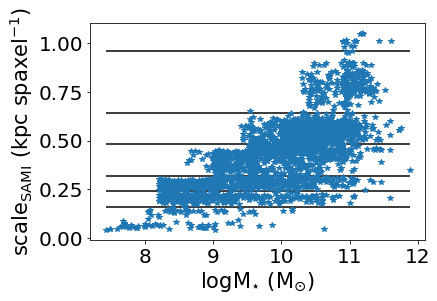

In [11]:
#The following is Extended Data Fig.1 in our paper.
scale_sami=arc2kpc*0.5
plt.plot(mstar,scale_sami,'*')
plt.xlabel('$\mathrm{\logM_{\star}}$ $\mathrm{(M_{\odot})}$')
plt.ylabel('$\mathrm{scale_{SAMI}}$ $\mathrm{(kpc\ spaxel^{-1})}$')
##We artificially divided the samples into seven groups of different scale regions.
plt.hlines(0.48,mstar.min(),mstar.max())
plt.hlines(0.32,mstar.min(),mstar.max())
plt.hlines(0.64,mstar.min(),mstar.max())
plt.hlines(0.16,mstar.min(),mstar.max())
plt.hlines(0.24,mstar.min(),mstar.max())
plt.hlines(0.96,mstar.min(),mstar.max())
indscag0=np.flatnonzero(scale_sami<0.16)
indscag1=np.flatnonzero((scale_sami>=0.16)*(scale_sami<0.24))
indscag2=np.flatnonzero((scale_sami>=0.24)*(scale_sami<0.32))
indscag3=np.flatnonzero((scale_sami>=0.32)*(scale_sami<0.48))
indscag4=np.flatnonzero((scale_sami>=0.48)*(scale_sami<0.64))
indscag5=np.flatnonzero((scale_sami>=0.64)*(scale_sami<0.96))
indscag6=np.flatnonzero((scale_sami>=0.96))

In [12]:
#Then the applications of COBS.

In [13]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
cobs=importr('cobs')

In [14]:
#First application，mstar vs chi2sumall.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>=0))
robjects.globalenv['m1']=robjects.FloatVector(mstar[inde1t])
robjects.globalenv['c1']=robjects.FloatVector(np.log10(chi2sumall[inde1t]))
mc50=robjects.r("mc50<-cobs(m1,c1,nknots=10,knots.add=TRUE,constraint='decrease')")
mc90=robjects.r("mc90<-cobs(m1,c1,nknots=length(mc50$knots),knots=mc50$knots,tau=0.9,constraint='decrease')")
mc10=robjects.r("mc10<-cobs(m1,c1,nknots=length(mc50$knots),knots=mc50$knots,tau=0.1,constraint='decrease')")
mc50pre=robjects.r("mc50pre<-predict(mc50,m1,interval='both')")
mc90pre=robjects.r("mc90pre<-predict(mc90,m1,interval='both')")
mc10pre=robjects.r("mc10pre<-predict(mc10,m1,interval='both')")
#robjects.r("mc50$knots")

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...

 Searching for missing knots ...


In [15]:
#Second application, surfB vs chi2sumall.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>=0))
robjects.globalenv['s1']=robjects.FloatVector(surfB[inde1t])
robjects.globalenv['c1']=robjects.FloatVector(np.log10(chi2sumall[inde1t]))
sc50=robjects.r("sc50<-cobs(s1,c1,knots.add=TRUE,constraint='decrease')")
sc90=robjects.r("sc90<-cobs(s1,c1,nknots=length(sc50$knots),knots=sc50$knots,tau=0.9,constraint='decrease')")
sc10=robjects.r("sc10<-cobs(s1,c1,nknots=length(sc50$knots),knots=sc50$knots,tau=0.1,constraint='decrease')")
sc50pre=robjects.r("sc50pre<-predict(sc50,s1,interval='both')")
sc90pre=robjects.r("sc90pre<-predict(sc90,s1,interval='both')")
sc10pre=robjects.r("sc10pre<-predict(sc10,s1,interval='both')")

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...

 Searching for missing knots ...


In [16]:
##Third application, surfB vs chiLsumall
inde1t=np.flatnonzero((chiLsumall>0)*(lenind2all>50)*(flagvescap>=0))
robjects.globalenv['s1']=robjects.FloatVector(surfB[inde1t])
robjects.globalenv['l1']=robjects.FloatVector(np.log10(chiLsumall[inde1t]))
sl50=robjects.r("sl50<-cobs(s1,l1,knots.add=TRUE)")
sl90=robjects.r("sl90<-cobs(s1,l1,nknots=length(sl50$knots),knots=sl50$knots,tau=0.9)")
sl10=robjects.r("sl10<-cobs(s1,l1,nknots=length(sl50$knots),knots=sl50$knots,tau=0.1)")
sl50pre=robjects.r("sl50pre<-predict(sl50,s1,interval='both')")
sl90pre=robjects.r("sl90pre<-predict(sl90,s1,interval='both')")
sl10pre=robjects.r("sl10pre<-predict(sl10,s1,interval='both')")

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...

 Searching for missing knots ...


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in log10


(-2, 0.5)

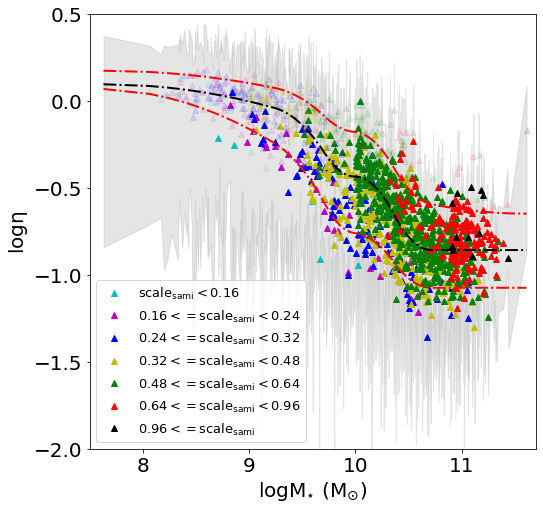

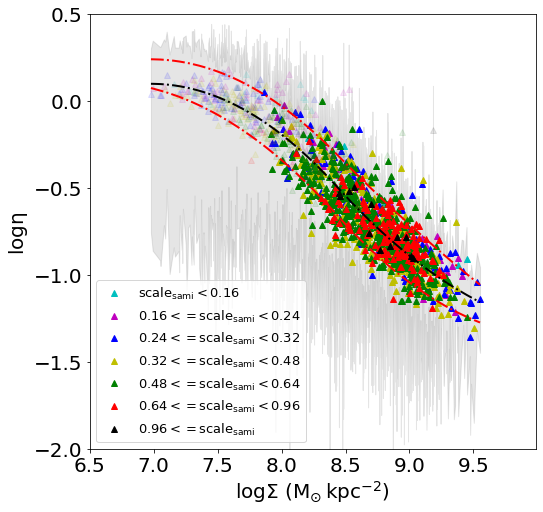

In [18]:
################
#The following is Fig.2a in our paper.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
fig,ax=plt.subplots(figsize=(8,8))
xrg=np.linspace(7,12,10000)
plt.plot(mstar[inde1t0],np.log10(chi2sumall[inde1t0]),'c^')
plt.plot(mstar[inde1t1],np.log10(chi2sumall[inde1t1]),'m^')
plt.plot(mstar[inde1t2],np.log10(chi2sumall[inde1t2]),'b^')
plt.plot(mstar[inde1t3],np.log10(chi2sumall[inde1t3]),'y^')
plt.plot(mstar[inde1t4],np.log10(chi2sumall[inde1t4]),'g^')
plt.plot(mstar[inde1t5],np.log10(chi2sumall[inde1t5]),'r^')
plt.plot(mstar[inde1t6],np.log10(chi2sumall[inde1t6]),'k^')
plt.legend(['$\mathrm{scale_{sami}<0.16}$','$\mathrm{0.16<=scale_{sami}<0.24}$','$\mathrm{0.24<=scale_{sami}<0.32}$','$\mathrm{0.32<=scale_{sami}<0.48}$','$\mathrm{0.48<=scale_{sami}<0.64}$','$\mathrm{0.64<=scale_{sami}<0.96}$','$\mathrm{0.96<=scale_{sami}}$'],fontsize=13)
plt.xlabel('$\mathrm{\logM_{\star}}$ $\mathrm{(M_{\odot})}$',fontsize=20)
plt.ylabel('$\mathrm{\log\eta }$',fontsize=20)
###############################
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap==0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
plt.plot(mstar[inde1t0],np.log10(chi2sumall[inde1t0]),'c^',alpha=0.1)
plt.plot(mstar[inde1t1],np.log10(chi2sumall[inde1t1]),'m^',alpha=0.1)
plt.plot(mstar[inde1t2],np.log10(chi2sumall[inde1t2]),'b^',alpha=0.1)
plt.plot(mstar[inde1t3],np.log10(chi2sumall[inde1t3]),'y^',alpha=0.1)
plt.plot(mstar[inde1t4],np.log10(chi2sumall[inde1t4]),'g^',alpha=0.1)
plt.plot(mstar[inde1t5],np.log10(chi2sumall[inde1t5]),'r^',alpha=0.1)
plt.plot(mstar[inde1t6],np.log10(chi2sumall[inde1t6]),'k^',alpha=0.1)
#########
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(mstar>=6)*(flagvescap>=0))
indsort=np.argsort(mstar[inde1t])
plt.fill_between(mstar[inde1t][indsort], np.log10(chi2nesumall)[inde1t][indsort], np.log10(2*chi2sumall-chi2nesumall)[inde1t][indsort], color='gray', alpha=0.2)
#########
######B-spline
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>=0))
lw=2
indargms=np.argsort(mstar[inde1t])
plt.plot(mstar[inde1t][indargms],mc50pre[:,1][indargms],'k-.',linewidth=lw)
plt.plot(mstar[inde1t][indargms],mc90pre[:,1][indargms],'r-.',linewidth=lw)
plt.plot(mstar[inde1t][indargms],mc10pre[:,1][indargms],'r-.',linewidth=lw)
#######
plt.xlim(7.5,11.7)
plt.ylim(-2,0.5)
#######
#The following is Fig.2b in our paper.
#######
#Choose galaxies with at least 50 spaxels inside Reff.
#flagvescap>0 are pure samples while flagvescap==0 are sub samples.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
fig,ax=plt.subplots(figsize=(8,8))
xrg=np.linspace(7,12,10000)
plt.plot(surfB[inde1t0],np.log10(chi2sumall[inde1t0]),'c^')
plt.plot(surfB[inde1t1],np.log10(chi2sumall[inde1t1]),'m^')
plt.plot(surfB[inde1t2],np.log10(chi2sumall[inde1t2]),'b^')
plt.plot(surfB[inde1t3],np.log10(chi2sumall[inde1t3]),'y^')
plt.plot(surfB[inde1t4],np.log10(chi2sumall[inde1t4]),'g^')
plt.plot(surfB[inde1t5],np.log10(chi2sumall[inde1t5]),'r^')
plt.plot(surfB[inde1t6],np.log10(chi2sumall[inde1t6]),'k^')
plt.legend(['$\mathrm{scale_{sami}<0.16}$','$\mathrm{0.16<=scale_{sami}<0.24}$','$\mathrm{0.24<=scale_{sami}<0.32}$','$\mathrm{0.32<=scale_{sami}<0.48}$','$\mathrm{0.48<=scale_{sami}<0.64}$','$\mathrm{0.64<=scale_{sami}<0.96}$','$\mathrm{0.96<=scale_{sami}}$'],fontsize=13)
plt.xlabel('$\mathrm{\log\Sigma}$ $\mathrm{(M_{\odot}\,kpc^{-2})}$',fontsize=20)
plt.ylabel('$\mathrm{\log\eta }$ ',fontsize=20)
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap==0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
plt.plot(surfB[inde1t0],np.log10(chi2sumall[inde1t0]),'c^',alpha=0.1)
plt.plot(surfB[inde1t1],np.log10(chi2sumall[inde1t1]),'m^',alpha=0.1)
plt.plot(surfB[inde1t2],np.log10(chi2sumall[inde1t2]),'b^',alpha=0.1)
plt.plot(surfB[inde1t3],np.log10(chi2sumall[inde1t3]),'y^',alpha=0.1)
plt.plot(surfB[inde1t4],np.log10(chi2sumall[inde1t4]),'g^',alpha=0.1)
plt.plot(surfB[inde1t5],np.log10(chi2sumall[inde1t5]),'r^',alpha=0.1)
plt.plot(surfB[inde1t6],np.log10(chi2sumall[inde1t6]),'k^',alpha=0.1)
#########
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(surfB>=6)*(flagvescap>=0))
indsort=np.argsort(surfB[inde1t])
plt.fill_between(surfB[inde1t][indsort], np.log10(chi2nesumall)[inde1t][indsort], np.log10(2*chi2sumall-chi2nesumall)[inde1t][indsort], color='gray', alpha=0.2)
######B-spline
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>=0))
indargsf=np.argsort(surfB[inde1t])
plt.plot(surfB[inde1t][indargsf],sc50pre[:,1][indargsf],'k-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sc90pre[:,1][indargsf],'r-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sc10pre[:,1][indargsf],'r-.',linewidth=lw)
#######
plt.xlim(6.5,9.99)
plt.ylim(-2,0.5)

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10


(-2, 0.5)

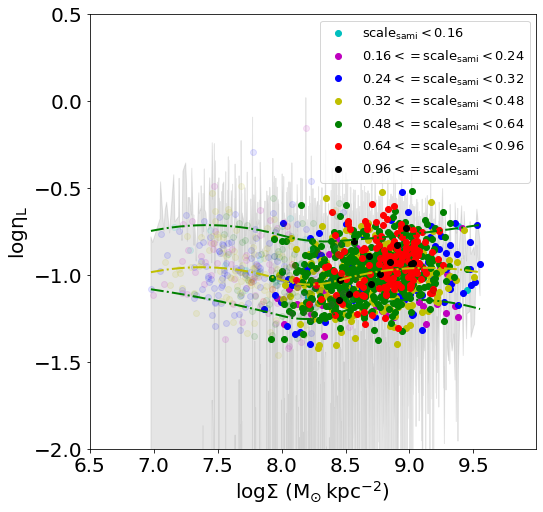

In [19]:
################
#The following is Fig.3a in our paper.
inde1t=np.flatnonzero((chiLsumall>0)*(lenind2all>50)*(flagvescap>0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
fig,ax=plt.subplots(figsize=(8,8))
xrg=np.linspace(7,12,10000)
plt.plot(surfB[inde1t0],np.log10(chiLsumall[inde1t0]),'co')
plt.plot(surfB[inde1t1],np.log10(chiLsumall[inde1t1]),'mo')
plt.plot(surfB[inde1t2],np.log10(chiLsumall[inde1t2]),'bo')
plt.plot(surfB[inde1t3],np.log10(chiLsumall[inde1t3]),'yo')
plt.plot(surfB[inde1t4],np.log10(chiLsumall[inde1t4]),'go')
plt.plot(surfB[inde1t5],np.log10(chiLsumall[inde1t5]),'ro')
plt.plot(surfB[inde1t6],np.log10(chiLsumall[inde1t6]),'ko')
plt.legend(['$\mathrm{scale_{sami}<0.16}$','$\mathrm{0.16<=scale_{sami}<0.24}$','$\mathrm{0.24<=scale_{sami}<0.32}$','$\mathrm{0.32<=scale_{sami}<0.48}$','$\mathrm{0.48<=scale_{sami}<0.64}$','$\mathrm{0.64<=scale_{sami}<0.96}$','$\mathrm{0.96<=scale_{sami}}$'],fontsize=13)
plt.xlabel('$\mathrm{\log\Sigma}$ $\mathrm{(M_{\odot}\,kpc^{-2})}$',fontsize=20)
plt.ylabel('$\mathrm{\log\eta_L }$ ',fontsize=20)
###############################
inde1t=np.flatnonzero((chiLsumall>0)*(lenind2all>50)*(flagvescap==0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
plt.plot(surfB[inde1t0],np.log10(chiLsumall[inde1t0]),'co',alpha=0.1)
plt.plot(surfB[inde1t1],np.log10(chiLsumall[inde1t1]),'mo',alpha=0.1)
plt.plot(surfB[inde1t2],np.log10(chiLsumall[inde1t2]),'bo',alpha=0.1)
plt.plot(surfB[inde1t3],np.log10(chiLsumall[inde1t3]),'yo',alpha=0.1)
plt.plot(surfB[inde1t4],np.log10(chiLsumall[inde1t4]),'go',alpha=0.1)
plt.plot(surfB[inde1t5],np.log10(chiLsumall[inde1t5]),'ro',alpha=0.1)
plt.plot(surfB[inde1t6],np.log10(chiLsumall[inde1t6]),'ko',alpha=0.1)
#########
inde1t=np.flatnonzero((chiLsumall>0)*(lenind2all>50)*(surfB>=6)*(flagvescap>=0))
indsort=np.argsort(surfB[inde1t])
plt.fill_between(surfB[inde1t][indsort], np.log10(chiLnesumall)[inde1t][indsort], np.log10(2*chiLsumall-chiLnesumall)[inde1t][indsort], color='gray', alpha=0.2)
######B-spline
inde1t=np.flatnonzero((chiLsumall>0)*(lenind2all>50)*(flagvescap>=0))
lw=2
indargsf=np.argsort(surfB[inde1t])
plt.plot(surfB[inde1t][indargsf],sl50pre[:,1][indargsf],'y-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sl90pre[:,1][indargsf],'g-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sl10pre[:,1][indargsf],'g-.',linewidth=lw)
#######
plt.xlim(6.5,9.99)
plt.ylim(-2,0.5)

Text(0, 0.5, '$\\mathrm{\\log\\eta}$ ')

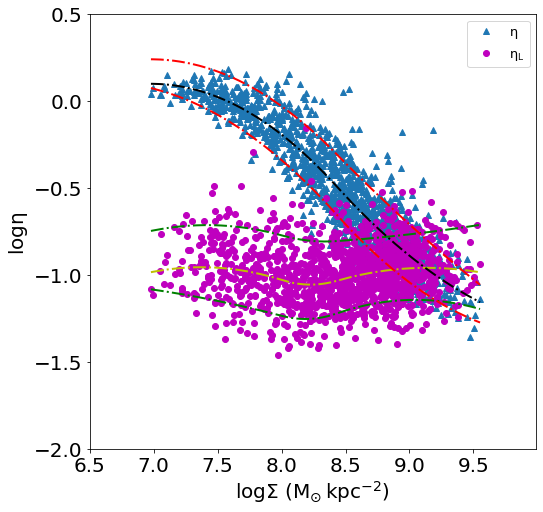

In [20]:
################
#The following is Fig.3b in our paper.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>=0))
fig,ax=plt.subplots(figsize=(8,8))
lw=2
indargsf=np.argsort(surfB[inde1t])
plt.plot(surfB[inde1t],np.log10(chi2sumall[inde1t]),'^',color='#1f77b4',alpha=1)
plt.plot(surfB[inde1t],np.log10(chiLsumall[inde1t]),'o',color='m')
plt.plot(surfB[inde1t][indargsf],sc50pre[:,1][indargsf],'k-.',zorder=3,linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sc90pre[:,1][indargsf],'r-.',zorder=3,linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sc10pre[:,1][indargsf],'r-.',zorder=3,linewidth=lw)
indargsf=np.argsort(surfB[inde1t])
plt.plot(surfB[inde1t][indargsf],sl50pre[:,1][indargsf],'y-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sl90pre[:,1][indargsf],'g-.',linewidth=lw)
plt.plot(surfB[inde1t][indargsf],sl10pre[:,1][indargsf],'g-.',linewidth=lw)
plt.xlim(6.5,9.99)
plt.ylim(-2,0.5)
plt.legend(['$\mathrm{\eta}$','$\mathrm{\eta_L}$'],fontsize=13)
plt.xlabel('$\mathrm{\log\Sigma}$ $\mathrm{(M_{\odot}\,kpc^{-2})}$',fontsize=20)
plt.ylabel('$\mathrm{\log\eta}$ ',fontsize=20)